In [1]:
import re
import pandas as pd
import nltk
import string
import numpy as np
import gensim
import time
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pandas import DataFrame,Series
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from translate import Translator
from langdetect import detect
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from gensim import corpora, models
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score,mean_squared_error
from sklearn import linear_model
from multiprocessing import cpu_count

#nltk.download('wordnet')

## input data and selection

In [2]:
pizzatop10=pd.read_csv("data/model/Pizzatop10count.csv",names=["number","name","info"])[["name","info"]][1:]
pizzatop10  ##read the top 10 pizza restaurant franchises information

,name,info
1,Pizza Hut,"[320, 'Restaurants, Italian, Pizza, Fast Food,..."
2,Domino's Pizza,"[209, 'Pizza, Caterers, Restaurants, Event Pla..."
3,Papa John's Pizza,"[152, 'Pizza, Restaurants']"
4,Little Caesars Pizza,"[112, 'Restaurants, Pizza']"
5,Pizza Pizza,"[102, 'Pizza, Restaurants, Italian, Chicken Wi..."
6,Boston Pizza,"[69, 'Pubs, Pizza, American (Traditional), Nig..."
7,Papa Murphy's,"[68, 'Restaurants, Pizza']"
8,Marco's Pizza,"[52, 'Italian, Restaurants, Pizza, Chicken Win..."
9,Pizza Nova,"[52, 'Restaurants, Pizza']"
10,Hungry Howie's Pizza,"[40, 'Restaurants, Pizza']"


In [3]:
reviewall=pd.read_csv("data/model/pizza_review.csv") # read all review file

In [4]:
user_weight = pd.read_csv('data//model//userweight.csv') # read user's weight file

In [5]:
reviewall['info']=reviewall['name'].map(pizzatop10.set_index('name')['info']) # add name to the review of top 10 pizza restaurant franchises
reviewtop10=reviewall.loc[reviewall['info'].isin(list(pizzatop10['info']))] # select the reivew of top 10 pizza restaurant franchises
reviewtop10[:5]

,Unnamed: 0,Unnamed: 0.1,business_id,cool,date,funny,review_id,stars,text,useful,user_id,name,info
18,267,267,fweCYi8FmbJXHCqLnwuk8w,0,2017-06-27 23:35:47,0,PnKm8y0thZ5ZdWhuOk7Opg,5.0,"Hands down, this is the best pizza place in Me...",0,VJvQiGrmtFXAmswRRIWYYw,Marco's Pizza,"[52, 'Italian, Restaurants, Pizza, Chicken Win..."
32,600,600,pif8Io-Jn2veckVGzkEyJw,0,2013-11-14 01:01:56,1,bLgMDEj1EXOuZ_94P5I7jA,4.0,I've never had a bad experience here.\n\ndeliv...,0,renPzRDqMZpMaHiCD_e1_A,Pizza Hut,"[320, 'Restaurants, Italian, Pizza, Fast Food,..."
38,751,751,C2skZUb7BLpv3e78Mcf5cA,0,2018-09-03 01:40:55,0,5haHR9yvGIUQ-sFMrAzsQQ,1.0,We order from this Pizza Hut often and always ...,0,txHu-M3p2tLKSpNGMWUO0Q,Pizza Hut,"[320, 'Restaurants, Italian, Pizza, Fast Food,..."
39,754,754,Idk-QTyUZq9w0ALh5cyvrw,0,2012-07-16 01:43:17,0,wv7sRqbptE9Vi9LziRN1uw,1.0,Flies on the pizza that was sitting out there....,0,bbRvR-IUOoXCuINsklDivw,Pizza Pizza,"[102, 'Pizza, Restaurants, Italian, Chicken Wi..."
90,1759,1759,zgtgMlvFk5Ilrs1yj78tdA,0,2015-08-19 12:59:20,3,mjJlAyWZ-Qzxb1kw61PwIA,4.0,So the owner of this restaurant called me back...,1,7VVLHIxJPP6_yREVf444sg,Hungry Howie's Pizza,"[40, 'Restaurants, Pizza']"


In [6]:
reviewtop10['text_len'] = reviewtop10['text'].apply(lambda x: len(x.split()))  # add the length of text to the selected review data

C:\Users\Tansu\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


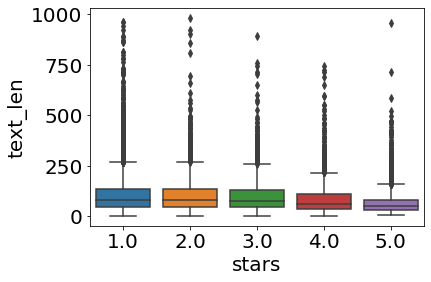

In [7]:
plt.figure(figsize=(6,4))  # check boxplot, we find that there are many outliers, thus we are going to delete them
plt.rcParams.update({'font.size': 20})
sns.boxplot(x = 'stars', y = 'text_len', data = reviewtop10)

In [8]:
reviewtop10=reviewtop10[reviewtop10['stars']!=3]  # delete unambiguous review
reviewtop10['star_b']=reviewtop10.stars.apply(lambda x: 1 if x>3 else 0) # add binary sentiment index to the selected review

In [9]:
reviewtop10_select=reviewtop10[(reviewtop10["text_len"]>30)&(reviewtop10["text_len"]<500)] # delete outliers in text_len

In [10]:
raw_index=reviewtop10_select.index # assigning user weight to the corresponding review
reviewtop10_select['weight']=reviewtop10_select['user_id'].map(user_weight.set_index('user_id')['weight'])
reviewtop10_select[reviewtop10_select['weight'].isnull()] # check assignment 

C:\Users\Tansu\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,Unnamed: 0.1,business_id,cool,date,funny,review_id,stars,text,useful,user_id,name,info,text_len,star_b,weight


In [11]:
#pd.DataFrame.to_csv(reviewtop10_select,'data//model//reviewtop10_select.csv',index=True) # save selected review

In [12]:
#reviewtop10_select=pd.read_csv('data//model//reviewtop10_select.csv',index_col=0) ## read selected review data

In [13]:
reviewtop10text=reviewtop10_select["text"]

In [14]:
len(reviewtop10text)

13319

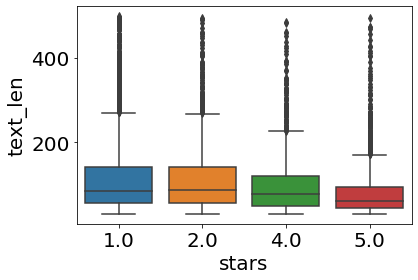

In [15]:
plt.figure(figsize=(6,4))  # check boxplot again
plt.rcParams.update({'font.size': 20})
sns.boxplot(x = 'stars', y = 'text_len', data = reviewtop10_select)

## Translation

In [16]:
translatereview=[]
for review in reviewtop10text:
    languagetype=detect(review)
    if languagetype=='en':
        translatereview.append(review)
    else:
        if languagetype=='es':
            lang='spanish'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='et':
            lang='estonian'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='fr':
            lang='french'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='hr':
            lang='croatian'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='it':
            lang='italian'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='pl':
            lang='polish'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='pt':
            lang='portuguese'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='sk':
            lang='slovak'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='so':
            lang='somali'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)
        elif languagetype=='sw':
            lang='swahili'
            translator= Translator(from_lang=lang,to_lang="english")
            translation = translator.translate(review)
            translatereview.append(translation)  

In [17]:
pd.DataFrame.to_csv(pd.DataFrame(translatereview),'data//model//translatereview.csv') #save the translated text data

In [16]:
translatereview=pd.read_csv('data//model//translatereview.csv')['0'] # read translated text data

In [17]:
print(len(translatereview),len(reviewtop10text))

13319 13319


In [18]:
len(translatereview)== len(reviewtop10text)# check if all the text has been translated

True

# Preprocessing

In [19]:
def text_to_sentence(textlist):  ## assign each sentenc in one review into a independent list
    sentencelist=[]
    for review in textlist:
        try:
            sentences=sent_tokenize(review)
            sentencelist.append(sentences)
        except:
            sentencelist.append(review)
    return sentencelist

In [20]:
stop_words = stopwords.words('english')  ## set stopwords
#stop_words2=['here']+['always']+['usually']+['often']+['are']+['was']+['were']+['did']+['have']+['will']+['gave']+['that']+['them']+['all']+['else']+['everyon']+['anoth']+['notknow']+['would']+['not']+['really']+['chines']+['continuously']+['afterwards']+['false']+['true']+['then']+['general']+['several']+['when']+['asap']+['even']+['also']+['back']+['plus']+['currently']+['mostly']+['fron']+['ummm']+['dine']+['square']+['4th']+['5th']+['ye']+['around']+['again']+['much']+['forth']+['wea']+['2nd']+['dominos']+['yet']+['somehow']+['non']+['hal']+['additional']+['toug']+['basically']+['bad']#
#stop_words2=['anyways']+['lat']+['whole']+['non']+['bad']+['always']+['back']+['also']+['even']+['speak']+['quickl']+['safe']+['female']+['3rd']+['out']+['middle']+['waiter']+['reallysure']+['nothingit']+['main']+['upse']+['yelp']+['ignoran']+['combo']+['current']+['true']+['false']+['dead']+['lol']+['when']+['thus']+['walked']+['evenly']+['aware']+['1st']+['already']+['why']+['then']+['4th']+['of']+['probabl']+['tall']+['howeve']+['thankfully']+['somehow']+['sometime']+['5th']+['2nd']
stop_words2=[]

In [21]:
def remove_stopwords(text):  ## remove stopwords
    pizza10clean=[]
    for review in text:
        s=[]
        for sentence in review:
            sentence = sentence.lower()
            if 'if' not in sentence:
                sentence = re.sub('not only (\w+?), but also', '\\1 and ', sentence) # change not only but also to and structure
                sentence=sentence.split(" ")
                sentence=[x for x in sentence if not x.strip() in stop_words] #delete pronowns and helping verbs
                sentence=" ".join(sentence)
                s.append(sentence)
        pizza10clean.append(s)
    return pizza10clean

In [22]:
def remove_stopwords2(text):  ## remove stopwords and integrate negative words with the following word if there exists
    pizza10clean=[]
    for review in text:
        s=[]
        for sentence in review:
            sentence = re.sub('n\'t\s', ' not', sentence)
            sentence = re.sub('not\s', ' not', sentence) #change not great to notgreat
            sentence = re.sub('never\s',' never',sentence) 
            sentence = re.sub('nothing\s',' nothing',sentence)
            sentence = re.sub('really\s',' really',sentence)
            sentence=sentence.translate(str.maketrans({key: None for key in string.punctuation})) #delete punctuation marks
            sentence=sentence.split(" ")
            sentence=[x for x in sentence if not x.strip() in stop_words2]
            for i in range (len(sentence)-1):
                if sentence[i].strip().startswith("not"):
                    sentence[i]=sentence[i]+sentence[i+1] #connect notgreat pizza into notgreatpizza
                    sentence[i+1]=""
            sentence=" ".join(sentence)
            s.append(sentence)
        pizza10clean.append(s)
    return pizza10clean

In [23]:
def text_to_words(text): ## allocate every word into one list in each review
    word_list=[]
    for review in text:
        word_list_review = []
        for sentence in review:
            word_list_review.extend(sentence.split())
        word_list.append(word_list_review)
    return word_list

In [24]:
def lemmatization(words_list): ## use spacy to flite words by part of speech and select negative connective words
    words_lem = []
    allowed_postags=['ADJ','ADV']
    nlp = spacy.load('en', disable=['parser', 'ner'])
    i=0
    for review in words_list:
        words_lem_review=[]
        doc = nlp(" ".join(review)) 
        words_lem_review.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        words_lem.append(words_lem_review[0])
        for words in review:
            neg_words=re.findall('not.+|never.+|nothing.+|never.+|really.+',words)
            words_lem[i].extend(neg_words)
        i+=1
    return words_lem

In [25]:
def delete_short_words(words_list):  ## delete the words whose lengths are less than 3
    for review in words_list:
        p = len(review)-1
        for words in reversed(review):
            if len(words) < 3:
                review.pop(p)
            p-=1
    return words_list

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [26]:
#stop_words3=['littl']+['gree']+['btw']+['rathe']+['yet']+['okay']+['general']+['due']+['multiple']+['together']+['clearly']+['online']+['again']+['brown']+['particularly']+['immediately']+['nevermind']+['welcome']+['ready']+['around']+['joint']+['likely']+['exact']+['prior']+['entire']+['severel']+['cashier']+['dominos']+['lovely']+['delis']+['sized']+['luckily']+['either']+['french']+['forth']+['anywa']+['drun']+['minor']+['everytime']+['perhaps']+['reallywant']+['somewhat']+['possibly']+['future']+['fancy']+['alone']+['luck']+['major']+['rather']+['total']+['several']+['absolutely']+['willing']+['give']+['loyal']+['now']+['wish']+['earlier']+['everywhere']+['canadian']+['previous']+['complete']+['common']+['half']+['supposedly']+['surprisingly']+['round']+['own']+['lucky']+['spoke']+['before']+['approximately']+['twic']+['actuall']+['edible']+['probably']+['regardless']+['therefore']+['kid']+['course']+['smart']+['kindly']
stop_words3=['again']+['still']+['back']+['nother']+['later']+['even']+['ever']+['away']+['there']+['totally']+['absolutely']+['2nd']+['yet']+['ago']+['always']+['last']+['first']+['false']+['true']

In [27]:
def remove_stopwords3(word_list):
    for review in word_list:
        p=len(review)-1
        for word in reversed(review):
            if word in stop_words3:
                review.pop(p)
            p-=1
    return word_list

In [28]:
def preprocess(textlist):
    #transreview_pro = list(map(stemSentence,textlist))
    pizza10sent=text_to_sentence(textlist)
    pizza10sent1=remove_stopwords(pizza10sent)
    pizza10sent2=remove_stopwords2(pizza10sent1)
    pizza10words=text_to_words(pizza10sent2)
    pizza10lem=lemmatization(pizza10words)
    pizza10lem2=delete_short_words(pizza10lem)
    words_out=remove_stopwords3(pizza10lem2)
    return words_out

In [29]:
init_time = time.time()
pizza10words = preprocess(translatereview)
time.time() - init_time

81.98631167411804

In [30]:
#with open('data/model/prepocessed_words.pkl', 'wb') as f: ##save prepocessed words 
#    pickle.dump(pizza10words, f)

In [31]:
#with open('data/model/prepocessed_words.pkl', 'rb') as f: ##read prepocessed words 
#   pizza10words = pickle.load(f)

In [32]:
dictionary = gensim.corpora.Dictionary(pizza10words)  ## construct dictionary for the LDA model
dictionary.filter_extremes(no_below=10, no_above=0.45) ## minimun occurrence is 10 and maximum occurrence ratio is 0.45
bow_corpus = [dictionary.doc2bow(doc) for doc in pizza10words] ## acquire the bow of each review ##

## use tf-idf with local weighting

In [33]:
def weigting_bow(bow): #define the weight function of each review
    p=0
    bow_w=[]
    for review in bow:
        bow_w_vec=[]
        for word in review:
            bow_w_vec.append((word[0],word[1]*(1+reviewtop10_select.iloc[p]['weight'])))
        bow_w.append(bow_w_vec)
    return bow_w

In [130]:
bow_corpus_w = weigting_bow(bow_corpus) ## weighting each bow corresponding to its user
tfidf = models.TfidfModel(bow_corpus_w) ## introducing local weighted tf-idf to modify corpus key value
bow_corpus_tfidf = tfidf[bow_corpus_w]

## Save Input Files

In [131]:
import pickle

with open('data/model/bow_corpus_tfidf.pkl', 'wb') as f:
    pickle.dump(bow_corpus_tfidf, f)
with open('data/model/dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

# LDA model building
## HDP Model to choose best topic number

from gensim.models import HdpModel
hdp = HdpModel(bow_corpus_tfidf, dictionary, chunksize=10000)
len(hdp.print_topics())

In [132]:
cores = cpu_count()-1
topic_num=20 ## set the number of topics for trainning model

In [133]:
import warnings
import logging
init_time = time.time()
lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=bow_corpus_tfidf,
                           num_topics=topic_num,
                           id2word=dictionary,
                           chunksize=100,
                           workers=cores, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
lda_train.save('data/model/lda_train.model')
time.time() - init_time

119.16839075088501

## Load Input Files and Trained Model

In [134]:
import pickle
with open('data/model/bow_corpus_tfidf.pkl', 'rb') as f:
    bow_corpus_tfidf = pickle.load(f)
with open('data/model/dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

In [135]:
#from gensim.test.utils import datapath
#model_file = datapath("C:/Users/Tansu/Desktop/UW-STAT628-M3/lda_train.model")
#lda = gensim.models.ldamodel.LdaModel.load(model_file)

# Model Validation

In [136]:
words2topics = []  ## construct the input X for the following regression model or classification model
for i in range(len(translatereview)):
    words2topics_vec = lda_train.get_document_topics(bow_corpus_tfidf[i], minimum_probability=0.001)
    words2topics_vec_1 = [words2topics_vec[i][1] for i in range(topic_num)]
    words2topics_vec_1.extend([len(reviewtop10_select.iloc[i].text)])
    words2topics_vec_1.extend([reviewtop10_select.iloc[i].useful])
    words2topics_vec_1.extend([reviewtop10_select.iloc[i].cool])
    words2topics_vec_1.extend([reviewtop10_select.iloc[i].funny])
    words2topics.append(words2topics_vec_1)

In [137]:
len(words2topics[0])

24

In [138]:
X = np.array(words2topics) ## X is the X matrix for the regression model or classification model
y = np.array(reviewtop10_select.stars)  ## y is the star labe and y_b is the binary sentiment label
y_b = np.array(reviewtop10_select.star_b)

## Linear Regression, Logistic Regression and Binary Logistic Regression

In [139]:
logistic_cv_f1 = []
linear_cv_mse = []
logistic_b_cv_f1 = []

kf = KFold(10, shuffle=True, random_state=375)

for train, valid in kf.split(X,y):
    X_train = X[train]
    y_train = y[train]
    X_valid = X[valid]
    y_valid = y[valid]
    y_b_train = y_b[train]
    y_b_valid = y_b[valid]


    ## scaling the X matrix
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_valid_scale = scaler.transform(X_valid)

    ## logistic regression
    logistic_cv = LogisticRegression(class_weight= 'balanced',solver='newton-cg',fit_intercept=True,multi_class='multinomial').fit(X_train_scale, y_train)
    y_pred = logistic_cv.predict(X_valid_scale)
    
    logistic_cv_f1.append(f1_score(y_valid, y_pred, average='weighted'))
    
    ## linear regression
    lr_model=LinearRegression(fit_intercept=False).fit(X_train,y_train)
    y_lr_pred=lr_model.predict(X_valid)
    
    linear_cv_mse.append(mean_squared_error(y_valid, y_lr_pred))
    
    ## binary logistic regression
    logistic_b_cv = LogisticRegression(class_weight= 'balanced',solver='sag').fit(X_train_scale,y_b_train)
    y_b_pred = logistic_b_cv.predict(X_valid_scale)
    logistic_b_cv_f1.append(f1_score(y_b_valid, y_b_pred, average='binary'))

In [140]:
print("MSE in linear regression is ",'{:.6}'.format(np.mean(linear_cv_mse)),"+-",'{:.4}'.format(np.std(linear_cv_mse)))
print("f1 score in logistic regression is ",'{:.6}'.format(np.mean(logistic_cv_f1)),"+-",'{:.4}'.format(np.std(logistic_cv_f1)))
print("f1 score in binary logistic regression is ",'{:.6}'.format(np.mean(logistic_b_cv_f1)),"+-",'{:.4}'.format(np.std(logistic_b_cv_f1)))

MSE in linear regression is  1.78975 +- 0.08572
f1 score in logistic regression is  0.536377 +- 0.01341
f1 score in binary logistic regression is  0.696858 +- 0.02038


## Random Forest

In [141]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_b, random_state=375)
estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=375)
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=375, splitter='best')

In [142]:
estimator.apply(X)

array([2, 3, 3, ..., 4, 3, 2], dtype=int64)

In [143]:
dp = estimator.decision_path(X_test)

In [144]:
y_rf_pred = estimator.predict(X_test)
f1_score(y_test, y_rf_pred, average='binary')

0.6294620412267471

## Output the words' weight in the classifier

In [145]:
word_num=50  ## set the number of words selected by each topic

In [146]:
raw_topic_words = lda_train.show_topics(num_topics=20, num_words=word_num, formatted=True)

In [147]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
logistic_b = LogisticRegression(class_weight= 'balanced',solver='sag',fit_intercept=True).fit(X_scale, y_b)


In [148]:
logistic_b.coef_[0]

array([-0.06332191, -0.18670757, -0.20396501,  0.01026525, -0.14973877,
        0.19308413, -0.13674919, -0.00147765, -0.19763781,  0.06305441,
       -0.3000436 ,  0.32488992,  0.99581043, -0.42822232, -0.11081305,
       -0.45933423, -0.07532046, -0.20560864, -0.1216007 ,  0.09931197,
       -0.35326751, -0.50576583,  1.4084825 , -0.51377205])

In [149]:
topics_words=[]
topic_index=0
for topic_index in range(topic_num):
    topics_words_vec=[]
    for word_index in range(word_num):
        topics_words_vec_1=[]
        topics_words_vec_1.append(float(raw_topic_words[topic_index][1].split('+ ')[word_index][:5])*logistic_b.coef_[0][topic_index])
        topics_words_vec_1.append(raw_topic_words[topic_index][1].split('+ ')[word_index][6:][1:-2])
        topics_words_vec.append(topics_words_vec_1)
    topics_words.extend(topics_words_vec)
    topic_index+=1

In [150]:
topics_words2 =[]
for pair in topics_words:
    if len(re.findall(pair[1], str(topics_words2))):
        for pair_2 in topics_words2:
            if (pair[1]==pair_2[1]):
                pair_2[0]+=pair[0]
    else:
        topics_words2.append(pair)

In [151]:
topics_words2[:5]

[[-0.003039451878008689, 'short'],
 [-0.002912808049758327, 'worst'],
 [-0.0036426695668254506, 'unfortunately'],
 [-0.002596198479132422, 'multiple'],
 [-0.002279588908506517, 'positive']]

In [152]:
print(len(topics_words),len(topics_words2))

1000 537


In [153]:
topics_words2 = pd.DataFrame(topics_words2).sort_values(0)
pd.DataFrame.to_csv(topics_words2,'data//model//words_weight_lda.csv',index=False)

In [154]:
topics_words2

,0,1
70,-0.049742,bad
72,-0.035477,cold
76,-0.035385,horrible
117,-0.030964,terrible
77,-0.025543,rude
...,...,...
204,0.031803,fast
328,0.035577,fresh
112,0.038367,good
206,0.042490,friendly


## Selecting noun words

### selecting adj word

In [155]:
positive_word=topics_words2[1][-5:]  ## find the 5 most positive words
positive_word=positive_word[::-1]

In [156]:
negative_word=topics_words2[1][:5]  ## find the 5 most negative words
negative_word=negative_word[::-1]

In [157]:
final_adj_list_lda=list(positive_word)+list(negative_word)  ## construct the extreme sentiment adj words list

In [158]:
##This function help choose sentences that contain the adjective words from the final adjective list.
def find_adj_sentence(text,aim_word_list):
    list1=[]
    index=[]
    for i in range (len(text)):
        list2 = []
        for sentence in text[i]:
            sentence=sentence.split()
            for word in sentence:
                if word in aim_word_list:
                    list2.append(" ".join(sentence))
                    break
        if len(list2):
            list1.append(list2)
            index.append(i)
    return list1,index

In [159]:
adj_sentence,index=find_adj_sentence(text_to_sentence(translatereview),final_adj_list_lda)  ## find the review containning extreme sentiment adj words

In [160]:
adj_sentence_info=[]  ##  find the restaurant information corresponding to the selected review
for i in index:
    adj_sentence_info.append((translatereview[i],reviewtop10_select.iloc[i]['stars'],reviewtop10_select.iloc[i]['name'],reviewtop10_select.iloc[i]['user_id'],reviewtop10_select.iloc[i]['weight']))

In [161]:
adj_nounlist=[]  ## find the noun related to the extreme sentiment adj word
noun_list = ['NN','NNS','NNPS','NNP'] 
for j in range (len(adj_sentence)):
    if adj_sentence[j]==[]:
        pass
    else:
        for sentence in adj_sentence[j]:
            tag=nltk.pos_tag(word_tokenize(sentence))
            for i in range(len(tag)):
                if tag[i][0] in final_adj_list_lda:
                    try:
                        if tag[i+1][1] in noun_list:
                            adj_nounlist.append((tag[i][0],tag[i+1][0],adj_sentence_info[j][2])) 
                    except:
                        if tag[i-1][1] in noun_list:
                            adj_nounlist.append((tag[i-1][0],tag[i][0],adj_sentence_info[j][2]))
                        else:
                            continue

## The noun and selected adjected words pair dictionary for pizzahut restaurant

In [162]:
final_adj_noun_dict_lda_pizzahut={}
for pair in adj_nounlist:
    if pair[2]=="Pizza Hut":
        if pair[0] in final_adj_list_lda:
            if pair[0] not in final_adj_noun_dict_lda_pizzahut:
                final_adj_noun_dict_lda_pizzahut[pair[0]]={pair[1]:1}
            else:
                if pair[1] not in final_adj_noun_dict_lda_pizzahut[pair[0]]:
                    final_adj_noun_dict_lda_pizzahut[pair[0]][pair[1]]=1
                else:
                    final_adj_noun_dict_lda_pizzahut[pair[0]][pair[1]]+=1
        elif pair[1] in final_adj_list_lda:
            if pair[1] not in final_adj_noun_dict_lda_pizzahut:
                final_adj_noun_dict_lda_pizzahut[pair[1]]={pair[0]:1}
            else:
                if pair[0] not in final_adj_noun_dict_lda_pizzahut[pair[1]]:
                    final_adj_noun_dict_lda_pizzahut[pair[1]][pair[0]]=1
                else:
                    final_adj_noun_dict_lda_pizzahut[pair[1]][pair[0]]+=1

In [163]:
final_adj_noun_dict_lda_pizzahut_sort={}
for key in final_adj_noun_dict_lda_pizzahut:
    final_adj_noun_dict_lda_pizzahut_sort[key]=sorted(final_adj_noun_dict_lda_pizzahut[key].items(),key=lambda x:x[1],reverse=True)

In [0]:
(final_adj_noun_dict_lda_pizzahut_sort['bad'][0][0]=='experience')|(final_adj_noun_dict_lda_pizzahut_sort['bad'][0][0]=='experience')

In [0]:
total1=0
for i in range (len(list(final_adj_noun_dict_lda_pizzahut_sort.values()))):
    pizzahutnoun_list=[x[1] for x in list(final_adj_noun_dict_lda_pizzahut_sort.values())[i]]
    total1+=sum(pizzahutnoun_list)
total1

## The noun and selected adjective word pairs dictionary for the other 9 top pizza restaurants

In [0]:
final_adj_noun_dict_lda_other9pizza={}
for pair in adj_nounlist:
    if pair[2]!="Pizza Hut":
        if pair[0] in final_adj_list_lda:
            if pair[0] not in final_adj_noun_dict_lda_other9pizza:
                final_adj_noun_dict_lda_other9pizza[pair[0]]={pair[1]:1}
            else:
                if pair[1] not in final_adj_noun_dict_lda_other9pizza[pair[0]]:
                    final_adj_noun_dict_lda_other9pizza[pair[0]][pair[1]]=1
                else:
                    final_adj_noun_dict_lda_other9pizza[pair[0]][pair[1]]+=1
        elif pair[1] in final_adj_list_lda:
            if pair[1] not in final_adj_noun_dict_lda_other9pizza:
                final_adj_noun_dict_lda_other9pizza[pair[1]]={pair[0]:1}
            else:
                if pair[0] not in final_adj_noun_dict_lda_other9pizza[pair[1]]:
                    final_adj_noun_dict_lda_other9pizza[pair[1]][pair[0]]=1
                else:
                    final_adj_noun_dict_lda_other9pizza[pair[1]][pair[0]]+=1

In [0]:
final_adj_noun_dict_lda_other9pizza_sort={}
for key in final_adj_noun_dict_lda_other9pizza:
    final_adj_noun_dict_lda_other9pizza_sort[key]=sorted(final_adj_noun_dict_lda_other9pizza[key].items(),key=lambda x:x[1],reverse=True)

In [0]:
for pair in final_adj_noun_dict_lda_other9pizza_sort['nice']:
    if pair[0] =='pizza' or pair[0]=='Pizza' or pair[0]=='pizzas':
        print(pair)

In [0]:
total2=0
for i in range (len(list(final_adj_noun_dict_lda_other9pizza_sort.values()))):
    othernoun_list=[x[1] for x in list(final_adj_noun_dict_lda_other9pizza_sort.values())[i]]
    total2+=sum(othernoun_list)

total2